# Semantic Textual Similarity


**Andrea Cerasani - 10680486** <br> **Fabio Chini - 10669966** <br> **Vincenzo Curreri - 10624628**

# Preliminary analysis

In machine learning, the **train-dev-test** split is a common technique used to evaluate the performance of a model and prevent overfitting. The dataset is divided into three subsets: the **training set**, the **development (or validation) set**, and the **test set**.

The benchmark comprises 8628 sentence pairs. This is the breakdown according to genres and train-dev-test splits:

                train  dev test total 
        -----------------------------
        news     3299  500  500  4299
        caption  2000  625  525  3250
        forum     450  375  254  1079
        -----------------------------
        total    5749 1500 1379  8628

We started by importing all the libraries needed to run the task

In [2]:
import pandas as pd
import numpy as np
from numpy import arccos
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from unidecode import unidecode
!pip install -U spacy
import spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              0.0/12.8 MB ? eta -:--:--
     -                                        0.4/12.8 MB 12.6 MB/s eta 0:00:01
     ----                                     1.5/12.8 MB 19.4 MB/s eta 0:00:01
     ---------                                3.0/12.8 MB 23.8 MB/s eta 0:00:01
     --------------                           4.8/12.8 MB 27.6 MB/s eta 0:00:01
     ----------------------                   7.1/12.8 MB 32.4 MB/s eta 0:00:01
     -----------------------------            9.4/12.8 MB 35.4 MB/s eta 0:00:01
     -------------------------------------   12.4/12.8 MB 50.4 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 40.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


We start by importing the three datasets: **train**, **test** and **dev** that we will use for our models, assigning each column a suitable title. As you can see, there are **5749**, **1500** and **1379** sentence pairs in the three datasets, respectively

In [4]:
def on_bad_line(values):
    return values[:7]

columns_mapping = {
    0: 'genre',
    1: 'filename',
    2: 'year',
    3: 'index',
    4: 'score',
    5: 'sentence1',
    6: 'sentence2'
}

# quotings 3 = csv.QUOTE_NONE
train_df = pd.read_csv('Dataset/sts-train.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'Shape of the Train Dataframe: {train_df.shape}')
train_df.head(10)

Shape of the Train Dataframe: (5749, 7)


,genre,filename,year,index,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
5,main-captions,MSRvid,2012test,11,4.25,Some men are fighting.,Two men are fighting.
6,main-captions,MSRvid,2012test,12,0.50,A man is smoking.,A man is skating.
7,main-captions,MSRvid,2012test,13,1.60,The man is playing the piano.,The man is playing the guitar.
8,main-captions,MSRvid,2012test,14,2.20,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...
9,main-captions,MSRvid,2012test,16,5.00,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.


In [5]:
dev_df = pd.read_csv('Dataset/sts-dev.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'Shape of the Dev Dataframe: {dev_df.shape}')

test_df = pd.read_csv('Dataset/sts-test.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'Shape of the Test Dataframe: {test_df.shape}')

Shape of the Dev Dataframe: (1500, 7)
Shape of the Test Dataframe: (1379, 7)


We now begin to **analyze** the train dataset. First we split each pair of sentences into two separate sentences, adding them into a single list, so that we have the **total number** of sentences present in the dataset

In [6]:
sentences1 = train_df["sentence1"]
sentences2 = train_df["sentence2"]
sentences_list = np.unique(np.concatenate((np.ravel(sentences1.values),np.ravel(sentences2.values))))

print(f"Total number of sentences: {len(sentences_list)}")

Total number of sentences: 10566


We preprocess the list of sentences, removing **special characters**, such as **punctuation** and **accents**, **stopwords** and applying **lemmatization**

In [7]:
def remove_special_chars(text):
    regex = '[' + punctuation + ']'
    return re.sub(regex,'',unidecode(text)).lower()

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize(text):
    parsed_sentence = spacy_nlp(str(text))
    lemmatized_sentence = ' '.join([word.lemma_ for word in parsed_sentence])
    return lemmatized_sentence


no_punct_sentences_list = np.array([remove_special_chars(string) for string in sentences_list])
clean_sentences_list = np.array([remove_stop_words(string) for string in no_punct_sentences_list])
lemmatized_sentences_list = np.array([remove_stop_words(lemmatize(remove_special_chars(sentence)).lower()) for sentence in clean_sentences_list])


print(f"Original list of sentences: {sentences_list[:5]}")

print(f"List of preprocessed sentences, without punctuation and stopwords: {clean_sentences_list[:5]}")

print(f"List of lemmatized sentences: {lemmatized_sentences_list[:5]}")

Original list of sentences: [' - Income, top rate:  percent.' ' Foxe was mostly frozen.'
 " billion . Everyone in the world at Mexico's current prosperity level."
 ' warmed.C from the year prior.'
 '"Americans don\'t cut and run, we have to see this misadventure through," she said.']
List of preprocessed sentences, without punctuation and stopwords: ['income top rate percent' 'foxe mostly frozen'
 'billion everyone world mexicos current prosperity level'
 'warmedc year prior' 'americans dont cut run see misadventure said']
List of lemmatized sentences: ['income top rate percent' 'foxe mostly frozen'
 'billion everyone world mexicos current prosperity level'
 'warmedc year prior' 'americans cut run see misadventure say']


In [15]:
array_len = np.vectorize(len)(sentences_list)
mean_len = np.mean(array_len)
print(f"Mean length of sentences in characters: {mean_len:.2f}")

Mean length of sentences in characters: 59.37


Here we find the **maximum** and **minimum** length of sentences, in words, representing it in a graph and showing the **average length** of sentences

Maximum sentence length: 56 words
Minimum sentence length: 2 words
Mean length of sentences in words: 10.17


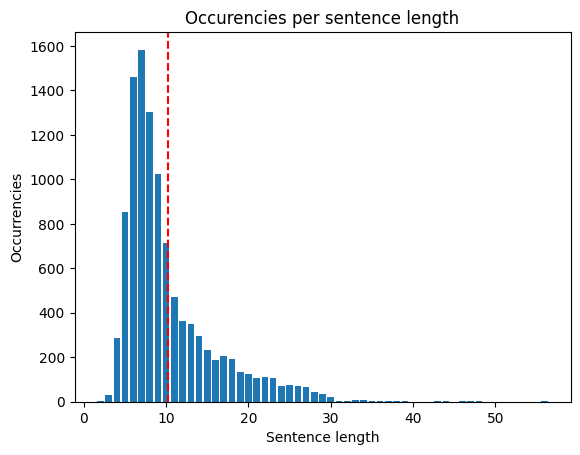

In [17]:
arr_words = np.array([len(s.split()) for s in sentences_list])

print(f"Maximum sentence length: {np.max(arr_words)} words")
print(f"Minimum sentence length: {np.min(arr_words)} words")

mean_sentences_length = np.mean(arr_words)
print(f"Mean length of sentences in words: {mean_sentences_length:.2f}")

unique, counts = np.unique(arr_words, return_counts=True)

plt.bar(unique, counts)

plt.axvline(x=mean_sentences_length, color='r', linestyle='--')

plt.xlabel("Sentence length")
plt.ylabel("Occurrencies")
plt.title("Occurencies per sentence length")


plt.show()

Here we show which **words** are the most **frequent** within the list of sentences

In [14]:
words_with_duplicates = [word for string in no_punct_sentences_list for word in word_tokenize(string)]
words_nostopwords = [w for w in words_with_duplicates if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(words_nostopwords)
counts_nostopwords.most_common(20)

[('man', 853),
 ('woman', 547),
 ('two', 458),
 ('said', 455),
 ('dog', 418),
 ('us', 402),
 ('white', 282),
 ('killed', 265),
 ('black', 258),
 ('playing', 254),
 ('percent', 253),
 ('new', 238),
 ('people', 217),
 ('syria', 211),
 ('china', 191),
 ('police', 173),
 ('running', 170),
 ('president', 168),
 ('person', 161),
 ('water', 156)]

Finally, we create the **vocabulary** by performing **tokenization** on all sentences, finding that there are **12243** different words

In [15]:
vocabulary = np.unique(words_nostopwords)
print(len(vocabulary))
print(vocabulary)

12243
['0' '004' '005' ... 'zubaidi' 'zuccarini' 'zuma']


In addition, we analyzed the **distribution** of **similarity scores**, representing it in a graph and showing the **average score**

Mean scores of sentence similarity: 2.70


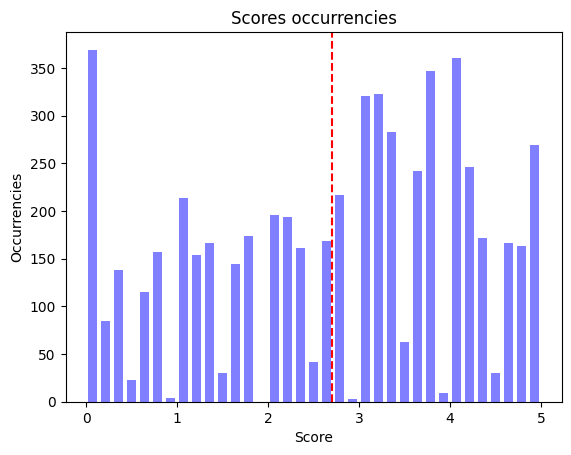

In [16]:
tot_scores = train_df["score"]
scores = np.ravel(tot_scores.values)

mean_scores = np.mean(scores);
print(f"Mean scores of sentence similarity: {mean_scores:.2f}")

plt.hist(scores, bins=35, alpha=0.5, color='blue', rwidth=0.7)

plt.axvline(x=mean_scores, color='r', linestyle='--')

plt.xlabel("Score")
plt.ylabel("Occurrencies")
plt.title("Scores occurrencies")

plt.show()

## Text Clustering

We begin by configuring the **TF-IDF (Term Frequency-Inverse Document Frequency)** method to process a set of sentences to obtain a **numerical representation** that reflects the importance of terms within the sentences.

We apply the TF-IDF method to the **lemmatized sentences** we have collected. We obtain a sparse matrix representing the **frequency** of terms in our corpus of sentences.

Finally, by extracting the vocabulary of unique terms used in the TF-IDF score calculation, we obtain a list of **relevant words** in our corpus.

In [64]:
# creazione della matrice di similarità
tfidf = TfidfVectorizer(max_df=0.8, min_df=0, stop_words='english', strip_accents='ascii')

tfidf_matrix = tfidf.fit_transform(lemmatized_sentences_list)
vocab = tfidf.get_feature_names_out()

print(tfidf_matrix.shape)
print(vocab)

(10566, 9857)
['004' '005' '006' ... 'zubaidi' 'zuccarini' 'zuma']


In [65]:
word = 'dog'
word_id = tfidf.transform([word]).nonzero()[1]
filter = tfidf_matrix.getcol(word_id).nonzero()[0]
print(f'The word {word} is present in {len(filter)} documents. Here\'s the first 5:')
for idx, text in enumerate(no_punct_sentences_list[filter][:5]):
    print(str(idx + 1) + '.' , text)

The word dog is present in 517 documents. Here's the first 5:
1. a baby is playing with a dog
2. a baby plays with a dog and ball
3. a bear is running from two dogs
4. a black and a brown dog running in the grass
5. a black and a yellow dog


We begin by specifying the desired number of **clusters** to group the sentences. Next, we use the **K-means algorithm** to assign each sentence to one of the clusters. The algorithm calculates the distance of the sentences from the **centroids** of the clusters and returns a matrix representing these distances.

Next, we use the nearest cluster index for each sentence to assign a **category** to each sentence. We count how many sentences are assigned to each cluster to get an idea of the number of sentences in each category.

Finally, we create a **graph** to display the number of sentences for each cluster, making it easier to understand the **distribution** of sentences within clusters.

[[1.14046735 1.08209408 1.18268806 ... 1.04827455 1.09872832 1.0003299 ]
 [1.14046735 1.08209408 1.18268806 ... 1.04827455 1.09872832 1.00084739]
 [1.14046735 1.08209408 1.18268806 ... 1.04613295 1.09872832 0.9991366 ]
 ...
 [1.14046735 1.08209408 1.18268806 ... 1.04770756 1.0982164  0.99900267]
 [1.14046735 1.08128212 1.18268806 ... 1.04827455 1.09768281 0.99755638]
 [1.14046735 1.07957184 1.17825067 ... 1.04741062 1.09872832 0.99843948]]
[26 29 29 ...  3  3 29]


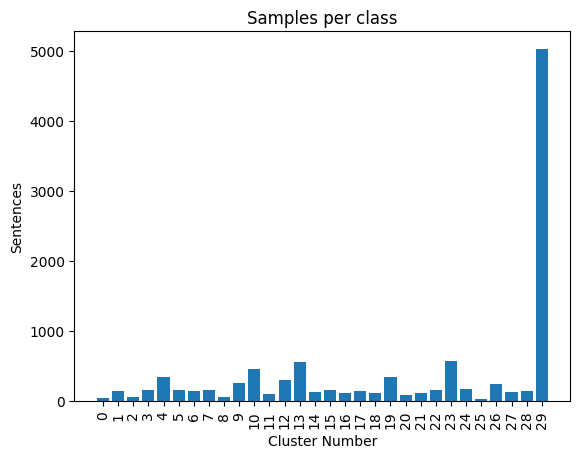

In [59]:
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(tfidf_matrix)
print(cluster_matrix)
clusters = np.argmin(cluster_matrix, axis=-1)
print(clusters)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Sentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class')
plt.show()

As we can see there is a very large cluster that might correspond to more common terms across the corpus. The other clusters though look well distributed

In [60]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['sheep', 'stand', 'black', 'field', 'hill']
Cluster 1:	['sit', 'table', 'people', 'man', 'woman']
Cluster 2:	['dance', 'woman', 'man', 'group', 'rain']
Cluster 3:	['small', 'international', 'end', 'myanmar', 'state']
Cluster 4:	['dog', 'run', 'snow', 'grass', 'brown']
Cluster 5:	['stock', 'close', 'high', 'low', 'open']
Cluster 6:	['korea', 'south', 'north', 'korean', 'nuclear']
Cluster 7:	['attack', 'kill', 'iraq', 'suicide', 'bomb']
Cluster 8:	['chemical', 'weapon', 'syria', 'use', 'destroy']
Cluster 9:	['play', 'man', 'guitar', 'boy', 'piano']
Cluster 10:	['woman', 'slice', 'cut', 'man', 'meat']
Cluster 11:	['train', 'track', 'station', 'crash', 'dead']
Cluster 12:	['kill', 'afghanistan', 'soldier', 'bomb', 'suicide']
Cluster 13:	['say', 'official', 'police', 'spokesman', 'mr']
Cluster 14:	['pakistan', 'kill', 'drone', 'strike', 'taliban']
Cluster 15:	['person', 'slice', 'cut', 'piece', 'onion']
Cluster 16:	['cat', 'white', 'look', 'black', 'play']

We now show the sentences belonging to **Cluster 4** (showing them from the list of sentences not preprocessed to improve readability). They appear to actually have arguments in common!

In [61]:
print(np.array(sentences_list)[kmeans.labels_ == 4][:10])

['A bear is running from two dogs.'
 'A black and a brown dog running in the grass.'
 'A black and a yellow dog'
 'A black and brown dog runs through the woods.'
 'A black and white dog is carrying a stick in its mouth.'
 'A black and white dog is running in the grass.'
 'A black and white dog is running on the beach.'
 'A black and white dog is running through a cow field.'
 'A black and white dog is running through grass.'
 'A black and white dog is running through the field.']


For each cluster, we are trying to figure out which terms are **most relevant** to that cluster and which sentences are most similar to its **centroid**.

We print the most important terms in the cluster and the top **10 sentences** most similar to its centroid. This helps us better understand the characteristics of the cluster and the representative sentences in it.

In [62]:
# print the top 10 words in each cluster
for i in range(k):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"\nCluster {i} - {[vocab[j] for j in sorted_terms[:5]]}:")

    i_labelled_sentence_vectors = tfidf_matrix[kmeans.labels_ == i]
    i_labelled_sentences = np.array(lemmatized_sentences_list)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_sentences = i_labelled_sentences[np.argsort(cosine_similarity(i_labelled_sentence_vectors, [centroid]).flatten())[::-1]]
    
    for idx, sentence in enumerate(sorted_sentences[:10]):
        print(str(idx + 1) + ") ",sentence)


Cluster 0 - ['sheep', 'stand', 'black', 'field', 'hill']:
1)  black white sheep walk next white sheep
2)  sheep stand tree
3)  group sheep field
4)  large dog stand next sheep field
5)  large sheep stand hill
6)  ten sheep look camera
7)  many sheep stand green hill
8)  group sheep hill
9)  white sheep stand green hill
10)  sheep stand near child

Cluster 1 - ['sit', 'table', 'people', 'man', 'woman']:
1)  four people sit table
2)  two people sit table restaurant
3)  group people sit around table food
4)  three man sit table drink
5)  group people sit restaurant table
6)  group people sit table restaurant
7)  man sit rock
8)  group people sit table drink
9)  three man suit sit table
10)  group elderly people sit around table

Cluster 2 - ['dance', 'woman', 'man', 'group', 'rain']:
1)  man dance
2)  man dance
3)  two man dance
4)  man dance
5)  three woman dance
6)  woman dance
7)  woman dance fire
8)  two woman dance
9)  man woman dance
10)  group man dance

Cluster 3 - ['small', 'int

We use a technique called **t-SNE** to reduce the complexity of the data and project it into a **two-dimensional graph**. Clearly **Cluster 29** is the largest, as can be seen from the graph.

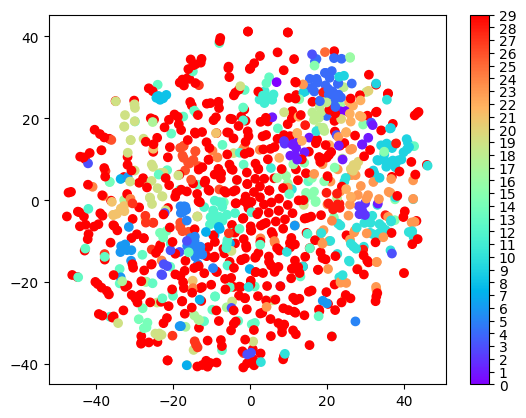

In [63]:
# visualize the clusters using manifold learning
from sklearn.manifold import TSNE
from matplotlib import ticker

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(tfidf_matrix.toarray()[::10])
# plot the clusters printng the color scale
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters[::10], cmap='rainbow')
# (generate plot here)
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=30)
cb.locator = tick_locator
cb.update_ticks()
plt.show()

No we use **Word2Vec** to generate meaningful word **embeddings** from the tokenized sentences. Then, we apply K-means clustering to group the word vectors into **clusters based** on their similarity. Finally, we plot the distribution of sentences assigned to each cluster.

In [26]:
from gensim.models import Word2Vec
# import word tokenizer
from nltk.tokenize import word_tokenize

tokenized_corpus = [word_tokenize(w) for w in lemmatized_sentences_list]
word2vec_cluster_model = Word2Vec(tokenized_corpus, vector_size=100, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)
print("vocabular size:", len(word2vec_cluster_model.wv.key_to_index))

vocabular size: 3121


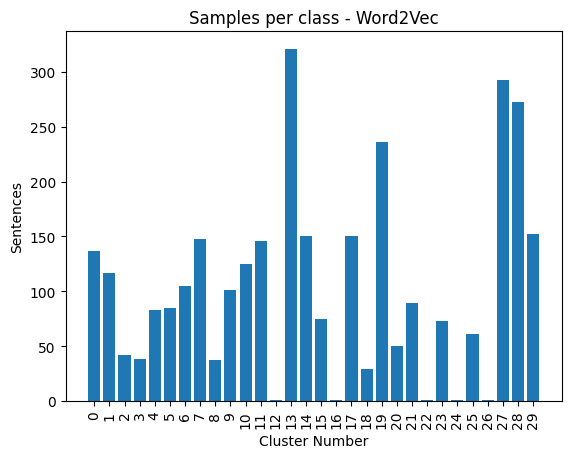

In [27]:
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(word2vec_cluster_model.wv.vectors)
clusters = np.argmin(cluster_matrix, axis=-1)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Sentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class - Word2Vec')
plt.show()

In [28]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    i_labelled_terms = np.array(word2vec_cluster_model.wv.index_to_key)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_terms = i_labelled_terms[np.argsort(cosine_similarity(word2vec_cluster_model.wv[i_labelled_terms], [centroid]).flatten())[::-1]]
    print(f"Cluster {i}:\t{[w for w in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['museum', 'overnight', 'coordinate', 'foe', 'fellow', 'deadly', 'nigeria', 'bali', 'eight', 'mortar']
Cluster 1:	['cruise', 'flight', 'francisco', 'runway', 'airline', 'asylum', 'object', 'float', 'vegas', 'malawi']
Cluster 2:	['withdrawal', 'participation', 'cfe', 'ratify', 'withdraw', 'amend', 'russias', 'treaty', 'deployment', 'soviet']
Cluster 3:	['elbaradei', 'invitation', 'aim', 'accept', '2007', 'campaign', 'initiative', 'deal', 'provide', 'jordan']
Cluster 4:	['donald', 'proceeding', 'overcome', 'lawyer', 'byrd', 'judiciary', 'request', 'grant', 'senate', 'response']
Cluster 5:	['sofa', 'lick', 'couch', 'table', 'bed', 'kitten', 'cat', 'furniture', 'wooden', 'laugh']
Cluster 6:	['rapper', 'assault', 'extortion', 'criminal', 'strausskahn', 'allege', 'corruption', 'evasion', 'conspiracy', 'trayvon']
Cluster 7:	['holder', 'nullification', 'permit', 'complaint', 'fundamental', 'wrong', 'law', 'excessive', 'liberty', 'lottery']
Cluster 8:	['last', 

## Topic Models

We use **CountVectorizer** to convert the lemmatized sentences into a **matrix** of word counts. Then, we apply **Latent Dirichlet Allocation (LDA)** to identify the main topics present in the text data.

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
count_matrix = count_vectorizer.fit_transform(lemmatized_sentences_list)
count_vocab = count_vectorizer.get_feature_names_out()

In [30]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=0, learning_method='online', max_iter=30)
lda.fit(count_matrix)

LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=30)

We print the top terms for each topic to gain insights into the main themes captured by the LDA model.

In [32]:
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(count_vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [state, stock, egypt, world, vote, index, election, tuesday, presidential, market]
Topic 2:	 [russia, rise, snow, horse, track, house, area, computer, bowl, lead]
Topic 3:	 [drug, face, case, plane, leave, hospital, indian, trade, home, fly]
Topic 4:	 [play, south, afghanistan, nato, troop, ball, service, guitar, fight, boy]
Topic 5:	 [group, day, air, international, say, look, expect, ban, national, general]
Topic 6:	 [china, hit, deal, company, wednesday, trial, 10, officer, second, 20]
Topic 7:	 [arm, little, rebel, tell, continue, begin, ask, base, party, pay]
Topic 8:	 [ride, young, boy, meet, public, night, pour, bush, video, people]
Topic 9:	 [woman, water, wear, billion, room, announce, pose, press, bicycle, picture]
Topic 10:	 [man, talk, high, large, city, dance, rock, onion, japan, sell]
Topic 11:	 [say, report, minister, palestinian, member, building, collapse, france, remain, month]
Topic 12:	 [arrest, slice, eat, long, fish, catch, immediately, yemen, spread, fe

We generate a **visual representatio**n of the most important terms and their weights for a set of predefined topics obtained from LDA. We show **Topic 2**, **Topic 10** and **Topic 26** as examples, noting that the **weights** may be unevenly distributed.

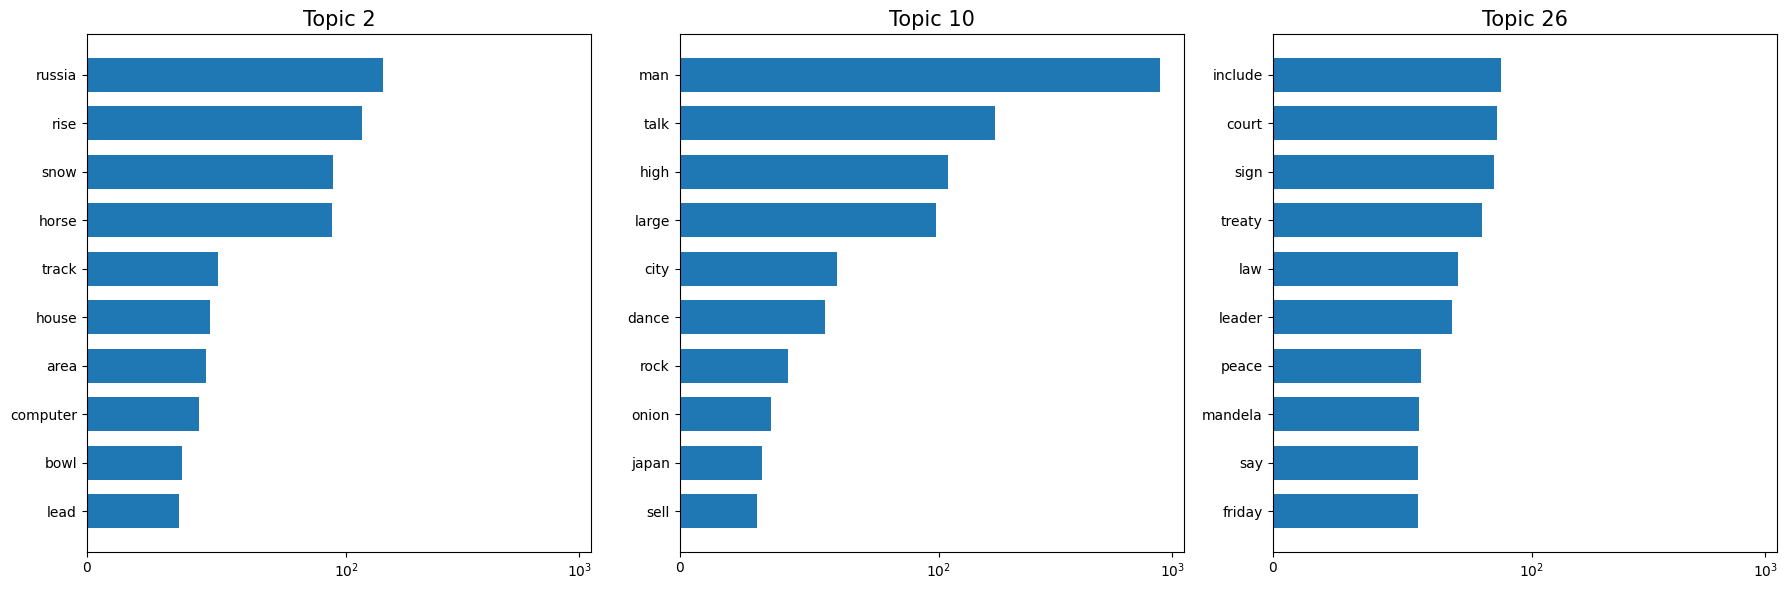

In [33]:
num_words = 10
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
topic_indices = [1, 9, 25]

for i, topic_idx in enumerate(topic_indices):
    topic = lda.components_[topic_idx]
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [count_vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[i]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('symlog', linthresh=100)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.20, hspace=0.3)
plt.tight_layout()
plt.show()


# Training models
We now turn our attention to the task of **sentence similarity**. In this context, we will utilize familiar models like **TF-IDF** and **Word2Vec**, which we have encountered earlier. Additionally, we will explore other approaches, such as Transformers.

## Bag of Words

Having just completed the training of a **TF-IDF** model for **clustering** purposes, we can further leverage this model to compute the similarity between sentences. With a **bag-of-words** approach, we can represent each sentence as a vector by considering the **frequency of words** in the sentence within the entire corpus. By comparing these vector representations, we can quantify the **similarity** between **sentences** based on their shared words and their respective frequencies.

In [36]:
def train_tfidf_vectorizer(sentences_list, max_df=0.8, min_df=5, remove_stopwords=True, ngram_range=(1,1)):
    """
    Train a TF-IDF vectorizer on the given sentences list.
    
    max_df: ignore terms that appear in more than max_df of the documents
    min_df: ignore terms that appear in less than min_df of the documents
    remove_stopwords: remove stopwords from the sentences
    preprocess_sentence: function to preprocess each sentence
    ngram_range: range of ngrams to consider
    """

    # Define TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_df=max_df, min_df=min_df, 
        stop_words='english' if remove_stopwords else None, 
        strip_accents='ascii',
        ngram_range=ngram_range
    )

    # Fit the vectorizer on the sentences and compute the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(sentences_list)
    tfidf_vocab = tfidf.get_feature_names_out()

    # Analyze results
    print(f"The dataset contains {len(tfidf_vocab)} terms")
    np.random.seed(41)
    random_sentence = np.random.choice(sentences_list)
    print("Random sentence:", random_sentence)
    random_sentence_tfidf_scores = tfidf.transform([random_sentence])
    sentence_df = pd.DataFrame({
        "id": random_sentence_tfidf_scores.nonzero()[1],
        "word": tfidf_vocab[random_sentence_tfidf_scores.nonzero()[1]],
        "scores": random_sentence_tfidf_scores.data
    })
    print(sentence_df.head())

    return tfidf, tfidf_matrix

This function calculates the **mean square error** (**MSE**) to assess how well a model predicts similarity between pairs of sentences. It takes as input a specific **model** and a **dataset** containing the sentence pairs and associated similarity scores. For each pair of sentences in the dataset, the model calculates the similarity between them using TF-IDF and stores the predicted scores.

### TODO: MODIFICARE O CANCELLARE

In [11]:
def evaluate_mse(model: TfidfVectorizer, dataset: pd.DataFrame):
    predicted_scores = []
    for idx, row in dataset.iterrows():
        a = row["sentence1"]
        b = row["sentence2"]
        vectorized_sentences = model.transform([a, b])
        similarity = cosine_similarity(vectorized_sentences)
        predicted_scores.append(similarity[0][1])

    return mean_squared_error(dataset["score"].values, predicted_scores)

In [12]:
def evaluate_pearson_correlation(model: TfidfVectorizer, dataset: pd.DataFrame):
    predicted_scores = []
    for idx, row in dataset.iterrows():
        a = row["sentence1"]
        b = row["sentence2"]
        vectorized_sentences = model.transform([a, b])
        similarity = cosine_similarity(vectorized_sentences)
        predicted_scores.append(similarity[0][1])

    return pearsonr(dataset["score"].values, predicted_scores)

In [24]:
clean_dataset = pd.DataFrame({
    'sentence1': train_df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': train_df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': train_df['score'] / 5
})

clean_test_dataset = pd.DataFrame({
    'sentence1': test_df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': test_df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': test_df['score'] / 5
})

In [42]:
def substitute_number(sentence):
    return re.sub(r'\d+', ' number ', sentence)

In [43]:
no_number_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(substitute_number),
    'sentence2': clean_dataset['sentence2'].map(substitute_number),
    'score': clean_dataset['score']
})

no_number_test_dataset = pd.DataFrame({
    'sentence1': clean_test_dataset['sentence1'].map(substitute_number),
    'sentence2': clean_test_dataset['sentence2'].map(substitute_number),
    'score': clean_test_dataset['score']
})

In [50]:
lemmatized_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(lemmatize),
    'sentence2': clean_dataset['sentence2'].map(lemmatize),
    'score': clean_dataset['score']
})

lemmatized_test_dataset = pd.DataFrame({
    'sentence1': clean_test_dataset['sentence1'].map(lemmatize),
    'sentence2': clean_test_dataset['sentence2'].map(lemmatize),
    'score': clean_test_dataset['score']
})

In [37]:
tfidf_vectorizer, tfidf_matrix = train_tfidf_vectorizer(clean_sentences_list, min_df=2)

The dataset contains 7447 terms
Random sentence: person hitchhiking road
     id    word    scores
0  5714    road  0.773089
1  4960  person  0.634297


Here we are printing the **most similar** sentences to a specific sentence based on **cosine similarity** using the **TF-IDF matrix**. This allows us to see both the original sentence and the **degree of similarity** calculated for every similar sentence.

In [44]:
tfidf_similarity = cosine_similarity(tfidf_matrix)
tfidf_sentence_idx = 10
print(sentences_list[tfidf_sentence_idx])
for i, col_idx in enumerate(tfidf_similarity[tfidf_sentence_idx].argsort()[::-1][1:6]):
    print(str(i+1) + ")",f"{tfidf_similarity[tfidf_sentence_idx][col_idx]:.2f} ", f"-> {sentences_list[col_idx]}")

"Biotech products, if anything, may be safer than conventional products because of all the testing," said Robert Fraley, Monsanto's executive vice president.
1) 0.75  -> "Biotech products, if anything, may be safer than conventional products because of all the testing," Fraley said, adding that 18 countries have adopted biotechnology.
2) 0.28  -> Products featuring Vanderpool will be released within five years, he said.
3) 0.27  -> As executive vice president of new ventures, Elias will report to Joe Tucci, EMC's president and chief executive.
4) 0.23  -> Bruce N. Hawthorne, 53, was named executive vice president and chief staff officer.
5) 0.22  -> Micronesia vice president to visit China


In [39]:
print("MSE:", evaluate_mse(tfidf_vectorizer, clean_test_dataset))

MSE: 0.07160480988860732


In [40]:
print("Pearson correlation:", evaluate_pearson_correlation(tfidf_vectorizer, clean_test_dataset).correlation)

Pearson correlation: 0.6050631337257831


We try to improve it using trigrams

In [45]:
trigrams_tfidf_vectorizer, _ = train_tfidf_vectorizer(clean_sentences_list, ngram_range=(1,3), min_df=2)
print("MSE:", evaluate_mse(trigrams_tfidf_vectorizer, clean_test_dataset))
#TODO cercare su internet comparazione performance bigrammi monogrammi

The dataset contains 21599 terms
Random sentence: person hitchhiking road
      id    word    scores
0  16397    road  0.773089
1  14211  person  0.634297
MSE: 0.08373522569616972


In [46]:
print("Pearson correlation:", evaluate_pearson_correlation(trigrams_tfidf_vectorizer, clean_test_dataset).correlation)

Pearson correlation: 0.5670972498472393


We try to improve by handling numbers

In [47]:
#TODO mostrare differenze tra originale e con [number]
no_number_sentences_list = [substitute_number(sentence) for sentence in clean_sentences_list]

number_tfidf_vectorizer, number_tfidf_matrix = train_tfidf_vectorizer(no_number_sentences_list, min_df=0)
print("MSE:", evaluate_mse(number_tfidf_vectorizer, no_number_test_dataset))

The dataset contains 11250 terms
Random sentence: person hitchhiking road
     id         word    scores
0  8458         road  0.502688
1  7303       person  0.412441
2  4602  hitchhiking  0.759735
MSE: 0.0695246220594747


we try to improve by lemmatizing the sentences

In [48]:
print("Pearson correlation:", evaluate_pearson_correlation(number_tfidf_vectorizer, no_number_test_dataset).correlation)

Pearson correlation: 0.6147825934090311


Now we try improving again using lemmatized sentences

In [83]:
lemmatized_tfidf_vectorizer, _ = train_tfidf_vectorizer(lemmatized_sentences_list, min_df=0)
print("MSE:", evaluate_mse(lemmatized_tfidf_vectorizer, lemmatized_test_dataset))

The dataset contains 9857 terms
Random sentence: person hitchhike road
     id       word    scores
0  7622       road  0.500708
1  6761     person  0.411840
2  4458  hitchhike  0.761366
MSE: 0.062183278052399954


In [84]:
print("Pearson correlation:", evaluate_pearson_correlation(lemmatized_tfidf_vectorizer, lemmatized_test_dataset).correlation)

Pearson correlation: 0.6610838992916482


In [46]:
# Saving the lemmatized sentences to a txt file
with open('Dataset/lemmatized_sentences.txt', 'w') as f:
    for item in lemmatized_sentences_list:
        f.write("%s\n" % item)

## Word2Vec

In [47]:
from gensim.models import Word2Vec

In [48]:
analyzer = lemmatized_tfidf_vectorizer.build_analyzer()
tokenized_corpus = [analyzer(w) for w in lemmatized_sentences_list]
model = Word2Vec(tokenized_corpus, vector_size=100, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)
print("vocabular size:", len(model.wv.key_to_index))

#print most similar words to
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model.wv.most_similar(item)])

vocabular size: 2994
car --> ['vehicle', 'bicycle', 'truck', 'motorcycle', 'amusement', 'nw', 'nightclub', 'sidewalk', 'bus', 'roadside']
boy --> ['kid', 'child', 'puppy', 'girl', 'man', 'woman', 'kitten', 'baby', 'person', 'garden']
man --> ['woman', 'girl', 'person', 'boy', 'guy', 'blanket', 'dog', 'white', 'gray', 'suit']
girl --> ['man', 'woman', 'hat', 'boy', 'panda', 'jacket', 'suit', 'scooter', 'shirt', 'gray']
woman --> ['man', 'girl', 'suit', 'person', 'gray', 'boy', 'counter', 'hat', 'lady', 'skateboard']
obama --> ['rebuild', 'house', 'bias', 'gop', 'religion', 'republicans', 'depend', 'supreme', 'annan', 'romney']
florida --> ['speaker', 'outfielder', 'university', 'veteran', 'pennsylvania', 'graham', 'select', 'bob', 'alaska', 'chris']
cat --> ['blanket', 'kitten', 'sheep', 'leather', 'dog', 'couch', 'animal', 'sofa', 'tube', 'paw']
dog --> ['puppy', 'animal', 'kitten', 'mouth', 'tan', 'panda', 'ear', 'duck', 'black', 'underwater']
blue --> ['pink', 'gray', 'orange', 'blac

In [49]:
model.save('word2vec.model')

In [50]:
def vectorize(sentences, vocab, vectorizer,  useSum=False, vector_size=100, tokenizer=lambda x: x.split()):
    # create a matrix with rows equal to the number of tweets and columns equal to the embedding size
    vectors = np.zeros((len(sentences), vector_size))

    # for each sentence in the dataset compute the embedding 
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        embeddings = [vectorizer(token) for token in tokens if token in vocab] # embedding per ogni token
        if (len(embeddings) > 0): # unisce tutti gli embedding in base a useSum
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

# modified version of vectorize that weightes the embeddings by the tf-idf score of the word
def vectorize_tfidf(sentences, vocab, vectorizer, tfidf_matrix, useSum=False, vector_size=100, tokenizer=lambda x: x.split()):
    # create a matrix with rows equal to the number of tweets and columns equal to the embedding size
    vectors = np.zeros((len(sentences), vector_size))

    # for each sentence in the dataset compute the embedding 
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        embeddings = [vectorizer(token) * tfidf_matrix[i, vocab.index(token)] for token in tokens if token in vocab] # embedding per ogni token
        if (len(embeddings) > 0): # unisce tutti gli embedding in base a useSum
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [51]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, model.wv, model.wv.get_vector, tokenizer=analyzer, useSum=False)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.127326568462908


In [52]:
import gensim.downloader as api

model_wiki = api.load("glove-wiki-gigaword-300")

In [53]:
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model_wiki.most_similar(item)])

car --> ['cars', 'vehicle', 'truck', 'driver', 'driving', 'vehicles', 'motorcycle', 'automobile', 'parked', 'drivers']
boy --> ['girl', 'boys', 'kid', 'man', 'teenage', 'child', 'teenager', 'father', 'girls', 'son']
man --> ['woman', 'person', 'boy', 'he', 'men', 'himself', 'one', 'another', 'who', 'him']
girl --> ['boy', 'woman', 'girls', 'teenager', 'teenage', 'mother', 'boys', 'child', 'teen', 'daughter']
woman --> ['girl', 'man', 'mother', 'she', 'her', 'female', 'herself', 'person', 'women', 'wife']
obama --> ['barack', 'mccain', 'bush', 'clinton', 'hillary', 'kerry', 'rodham', 'biden', 'gore', 'democrats']
florida --> ['miami', 'fla.', 'carolina', 'texas', 'tallahassee', 'louisiana', 'alabama', 'jacksonville', 'tampa', 'arizona']
cat --> ['dog', 'cats', 'pet', 'dogs', 'feline', 'monkey', 'horse', 'pets', 'rabbit', 'leopard']
dog --> ['dogs', 'cat', 'pet', 'puppy', 'hound', 'horse', 'animal', 'cats', 'canine', 'pets']
blue --> ['red', 'yellow', 'purple', 'pink', 'bright', 'black',

In [54]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, model_wiki, model_wiki.get_vector,  tokenizer=analyzer, useSum=False, vector_size=300)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    
    # Angular similarity
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.12841044500310017


## SubWord embedding: FastText

In [55]:
import fasttext
from gensim.models import FastText

In [56]:
ft_model = fasttext.train_unsupervised('Dataset/parsed_sentences.txt', model='cbow', dim=100, minCount=3, minn=3, maxn=5, ws=5, epoch=100)

for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [s for w, s in ft_model.get_nearest_neighbors(item)])

car --> ['cartoon', 'care', 'carrot', 'carry', 'cartel', 'cargo', 'career', 'carpet', 'carrier', 'carolina']
boy --> ['bo', 'puppy', 'kid', 'skirt', 'boat', 'jacket', 'float', 'boot', 'a', 'girl']
man --> ['woman', 'a', 'an', 'many', 'math', 'human', 'jean', 'chapman', 'suit', 'zimmerman']
girl --> ['young', 'woman', 'blonde', 'helmet', 'skirt', 'piano', 'guy', 'sidewalk', 'pink', 'sit']
woman --> ['man', 'a', 'womans', 'girl', 'someoen', 'an', 'kangaroo', 'person', 'helmet', 'human']
obama --> ['obamas', 'obamacare', 'osama', 'alabama', 'romney', 'lama', 'vow', 'secretary', 'hamas', 'secret']
florida --> ['fda', 'graham', 'fla', 'birthday', 'pennsylvania', 'nevada', 'outfielder', 'sixth', 'switzerland', '27th']
cat --> ['carpet', 'cap', 'camera', 'canoe', 'kitten', 'catch', 'caucus', 'cake', 'carrot', 'cattle']
dog --> ['mouth', 'fluffy', 'run', 'brown', 'puppy', 'kitten', 'snow', 'doorway', 'poodle', 'youth']
blue --> ['bluechip', 'black', 'skirt', 'jetblue', 'blanket', 'blonde', 'sq

In [57]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize(sentences, ft_model.words, ft_model.get_word_vector, tokenizer=analyzer, useSum=False)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.1150233961074313


In [58]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = vectorize_tfidf(sentences, ft_model.words, ft_model.get_word_vector, tfidf_matrix=tfidf_matrix, tokenizer=analyzer, useSum=False)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.08737958902992013


In [59]:
predicted_scores = []
for idx, row in lemmatized_dataset.iterrows():
    sentences = [row['sentence1'], row['sentence2']]
    vectors = ft_model.get_sentence_vector(sentences[0]), ft_model.get_sentence_vector(sentences[1])
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

MSE: 0.11355038530961754


In [60]:
ft_model.get_analogies("man", "boy", "girl")

[(0.5787145495414734, 'woman'),
 (0.3870006799697876, 'male'),
 (0.3802955448627472, 'human'),
 (0.37726593017578125, 'tan'),
 (0.3590967357158661, 'teenager'),
 (0.3566783666610718, 'chicken'),
 (0.35666173696517944, 'eagle'),
 (0.35350024700164795, 'jean'),
 (0.34888580441474915, 'manning'),
 (0.3341067433357239, 'a')]

## Transformers

### Unsupervised approaches

In [61]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
embeddings = model.encode(clean_sentences_list, convert_to_tensor=True)


c:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
hits = util.semantic_search(embeddings[0], embeddings, top_k=20)
hits = hits[0]      #Get the hits for the first query
for hit in hits:
    print(clean_sentences_list[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

income top rate percent (Score: 1.0000)
income tax top rate percent (Score: 0.8817)
capital gains top rate percent (Score: 0.6926)
higher per cent high (Score: 0.5817)
survey found median household income rose 51 accounting inflation 43057 (Score: 0.5806)
median household income declined 11 percent 2001 2002 42409 accounting inflation (Score: 0.5753)
unemployment rate rose tenth percentage point 61 highest level since july 1994 (Score: 0.5456)
revenue rose 39 percent 163 billion 157 billion (Score: 0.5443)
unemployment rate predicted ticked percentage point 61 (Score: 0.5028)
based separate survey households unemployment rate fell august 61 percent 62 percent (Score: 0.4906)
proportion people covered employers dropped 623 percent 2001 613 percent last year (Score: 0.4882)
halliburton 1q income rises 23 pct (Score: 0.4704)
wall street dow jones industrial average rose 05 per cent 99058 nasdaq composite added 07 per cent 19951 (Score: 0.4628)
stocks edge lower following retail earnings (

In [63]:
stop_words_embeddings = model.encode(no_punct_sentences_list, convert_to_tensor=True)

In [64]:
hits = util.semantic_search(stop_words_embeddings[0], stop_words_embeddings[1], top_k=20)
hits = hits[0]      #Get the hits for the first query
for hit in hits:
    print(no_punct_sentences_list[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

  income top rate  percent (Score: 0.0237)


In [65]:
predicted_scores = []
for idx, row in tqdm(lemmatized_dataset.iterrows()):
    sentences = [row['sentence1'], row['sentence2']]
    vectors = model.encode(sentences)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(similarity)

mse = mean_squared_error(lemmatized_dataset["score"].values, predicted_scores)
print("MSE:", mse)

5749it [02:06, 45.50it/s]


MSE: 0.051328593426690855


In [66]:
# min max scale predicted scores
from sklearn.preprocessing import Normalizer, MinMaxScaler
predicted_scores = np.array(predicted_scores)
scaled_predicted_scores = predicted_scores

scaled_predicted_scores
scaled_predicted_scores.shape

(5749,)

In [67]:
mse = mean_squared_error(lemmatized_dataset["score"].values, scaled_predicted_scores)
print("MSE:", mse)

MSE: 0.051328593426690855


In [68]:
predicted_scores = []
for idx, row in tqdm(train_df.iterrows()):
    sentences = [row['sentence1'], row['sentence2']]
    vectors = model.encode(sentences)
    similarity = cosine_similarity(vectors)[0][1]
    similarity = np.clip(similarity, -1, 1)
    predicted_scores.append(1 - (arccos(similarity) / np.pi))

mse = mean_squared_error(train_df["score"].values, predicted_scores)
print("MSE:", mse)

5749it [02:34, 37.20it/s]

MSE: 5.683979713559597


#TODO fine tuning the model using cosine similarity as loss function [link](https://www.sbert.net/examples/training/sts/README.html)

#TODO testing tf-idf with trainset

#TODO adjust lemmatized_dataset with lower after lemmatization and stopwords

In [79]:
"""
This examples trains a CrossEncoder for the STSbenchmark task. A CrossEncoder takes a sentence pair
as input and outputs a label. Here, it output a continious labels 0...1 to indicate the similarity between the input pair.

It does NOT produce a sentence embedding and does NOT work for individual sentences.

Usage:
python training_stsbenchmark.py
"""
from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from sentence_transformers import InputExample
import logging
from datetime import datetime
import sys
import os
import gzip
import csv

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout



#Define our Cross-Encoder
train_batch_size = 16
num_epochs = 4
model_save_path = 'output/training_stsbenchmark-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#We use distilroberta-base as base model and set num_labels=1, which predicts a continous score between 0 and 1
model = CrossEncoder('distilroberta-base', num_labels=1)



# Read STSb dataset
logger.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []
test_samples = []

for idx, row in train_df.iterrows():

    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1

    #As we want to get symmetric scores, i.e. CrossEncoder(A,B) = CrossEncoder(B,A), we pass both combinations to the train set
    train_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))
    train_samples.append(InputExample(texts=[row['sentence2'], row['sentence1']], label=score))

for idx, row in dev_df.iterrows():
    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
    dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

for idx, row in test_df.iterrows():
    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
    test_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))


# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)


# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='sts-dev')


# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)


##### Load model and eval on test set
model = CrossEncoder(model_save_path)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

2023-05-25 22:57:01 - Use pytorch device: cpu
2023-05-25 22:57:01 - Read STSbenchmark train dataset
2023-05-25 22:57:02 - Warmup-steps: 288


Epoch:   0%|          | 0/4 [08:37<?, ?it/s]


KeyboardInterrupt: 

In [77]:
for row in train_df.iterrows():
    score = float(row[1]['score']) / 5.0  # Normalize score to range 0 ... 1
    print(score)

1.0
0.76
0.76
0.52
0.85
0.85
0.1
0.32
0.44000000000000006
1.0
0.8400000000000001
0.9199999999999999
0.7734
0.9334
0.33340000000000003
0.75
1.0
0.1
0.76
1.0
0.64
0.5599999999999999
0.9199999999999999
0.6
1.0
0.96
1.0
0.8400000000000001
0.8400000000000001
0.8
0.8
0.9818
0.6
0.48
0.8400000000000001
0.6799999999999999
1.0
0.75
0.55
1.0
0.8
0.72
0.32
0.35
1.0
0.2
0.2
0.475
0.76
0.64
0.64
0.8800000000000001
0.75
0.95
0.64
0.31120000000000003
0.7876000000000001
1.0
1.0
0.8
0.32
0.95
0.7
0.27999999999999997
0.27999999999999997
0.8
1.0
0.7666000000000001
0.12
0.5833999999999999
0.8400000000000001
0.4
0.52
0.32
0.4
0.8400000000000001
0.4
0.96
0.8800000000000001
1.0
0.6
0.85
0.85
0.76
0.48
0.32
0.4
0.32
0.8
0.44000000000000006
0.8800000000000001
0.72
0.72
0.1
0.16
0.12
0.52
0.4
0.44000000000000006
0.48
0.72
0.44000000000000006
0.96
0.3286
0.35
0.45
0.8
0.96
0.64
0.8
0.8800000000000001
0.9199999999999999
0.76
0.96
0.9714
1.0
0.5065999999999999
0.2
0.2
0.4
0.028599999999999997
0.4
0.32
0.32
0.67999